## Initial Setup

In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.6 MB/s eta 0:00:00


In [2]:
pip install tensorflow tensorflow-hub tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 35.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project')

In [6]:
import pandas as pd
import numpy as np
import keras
from keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet201
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.utils import resample
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
import sklearn.metrics as m
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow_hub as hub

## Data Pre-Processing

In [7]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/ISIC2018_Task3_Training_GroundTruth.csv')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
base_path = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/train/images/'
df['img_path'] = base_path + df['image']+'.jpg'
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,img_path
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/drive/MyDrive/Colab Notebooks/skin-ca...


In [9]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
df['label'] = df[classes].idxmax(axis=1)
target_counts = {"AKIEC":1200, "BCC":1200, "BKL":1200, "DF":1200, "NV":1200, "MEL":1200, "VASC":1200}
df_balanced = pd.DataFrame(columns=df.columns)

for label, target_count in target_counts.items():
    df_class = df[df['label'] == label]
    current_count = len(df_class)

    if current_count < target_count:
        # Upsample
        df_class_balanced = resample(df_class, replace=True, n_samples=target_count, random_state=42)
    else:
        # Downsample
        df_class_balanced = resample(df_class, replace=False, n_samples=target_count, random_state=42)

    df_balanced = pd.concat([df_balanced, df_class_balanced])

df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
total = sum(target_counts.values())
total

8400

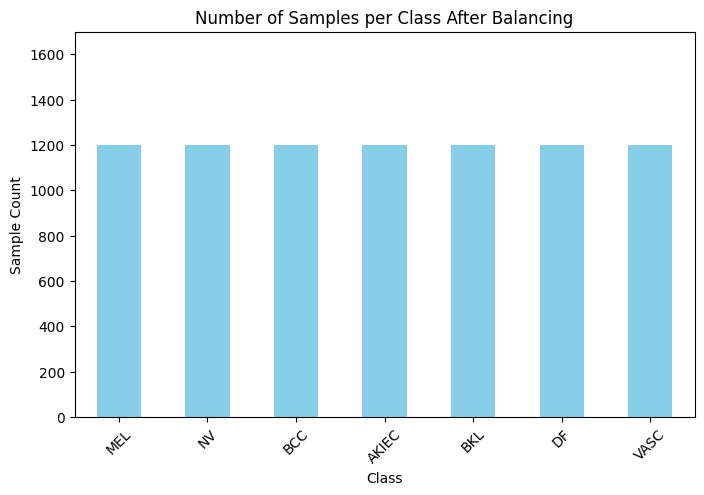

In [11]:
class_counts = df[classes].sum()

# Plot bar chart
plt.figure(figsize=(8,5))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Samples per Class After Balancing')
plt.ylabel('Sample Count')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, max(class_counts) + 500)
plt.show()

In [12]:
augmenter = keras.Sequential([
    keras.layers.RandomRotation(factor=0.2),
])

def load_and_preprocess_image(path, label, training=False):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)

    if training:
        image = augmenter(image)

    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    return image, label

def create_dataset(df, training=False, batch_size=8):
    image_path = df['img_path'].values
    labels = df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values
    dataset = tf.data.Dataset.from_tensor_slices((image_path, labels))

    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, training),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if training:
        dataset = dataset.shuffle(512)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

df_train = create_dataset(df, training=True)

In [13]:
# Capture Ground Truth and transform dataframe for label use

df_validate = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/ISIC2018_Task3_Validation_GroundTruth.csv')
base_path_validate = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/validate/images/'
df_validate['img_path'] = base_path_validate + df_validate['image']+'.jpg'

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/ISIC2018_Task3_Test_GroundTruth.csv')
base_path_test = '/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/datasets/test/images/'
df_test['img_path'] = base_path_test + df_test['image']+'.jpg'

In [14]:
df_validate = create_dataset(df_validate, training=False)
df_test = create_dataset(df_test, training=False)

## Model

In [15]:
def plot_hist(hist, modelName):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title(f"{modelName} model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model Building and Training


In [16]:
vit_url = "https://tfhub.dev/sayakpaul/vit_b32_fe/1"
vit_layer = hub.KerasLayer(vit_url, trainable=True)

In [17]:
def build_model():
  num_classes=7

  inputs = layers.Input(shape=(224, 224, 3))
  x = layers.Lambda(lambda img: vit_layer(img))(inputs)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.3)(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x)

  model = models.Model(inputs, outputs)

  learning_rate = 9e-4

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss='categorical_crossentropy',
      metrics=['accuracy']
      )

  return model

model = build_model()

In [18]:
total_params = model.count_params()
print(f"Total Parameters: {total_params:,}")

Total Parameters: 397,319


In [19]:
# Floting Points Operations (FLOPs) calculation

input_shape = [1] + list(model.input.shape[1:])
concrete_func = tf.function(lambda x: model(x))
concrete_func = concrete_func.get_concrete_function(
    tf.TensorSpec(input_shape, model.inputs[0].dtype))

frozen_func = convert_variables_to_constants_v2(concrete_func)
graph_def = frozen_func.graph.as_graph_def()

with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name="")
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    flops = tf.compat.v1.profiler.profile(graph=graph,
                                          run_meta=run_meta,
                                          cmd='op',
                                          options=opts)

    print(f"\nTotal FLOPs: {flops.total_float_ops:,}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.



Total FLOPs: 794,154


In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
start_time = time.time()
hist = model.fit(df_train,epochs=30,validation_data=df_validate,callbacks=[learning_rate_reduction])
end_time = time.time()
duration = end_time - start_time
print(f"Model ViT-B32 Training Time: {duration:.2f} seconds ({duration / 60:.2f} minutes)")

Epoch 1/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 827s 697ms/step - accuracy: 0.5279 - loss: 1.4863 - val_accuracy: 0.6995 - val_loss: 0.8151 - learning_rate: 9.0000e-04
Epoch 2/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.6756 - loss: 0.8300 - val_accuracy: 0.7358 - val_loss: 0.6899 - learning_rate: 9.0000e-04
Epoch 3/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7174 - loss: 0.7231 - val_accuracy: 0.7047 - val_loss: 0.7437 - learning_rate: 9.0000e-04
Epoch 4/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7447 - loss: 0.6720 - val_accuracy: 0.6788 - val_loss: 0.7761 - learning_rate: 9.0000e-04
Epoch 5/30
1049/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7655 - loss: 0.6291
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00044999999227002263.
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - accuracy: 0.7655 - loss: 0.6291 - val_accuracy: 0.6788 - val_loss: 0.8950 - learning_rate: 9.0000e-04
Epoch 6/30
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3

## Model Evaluation

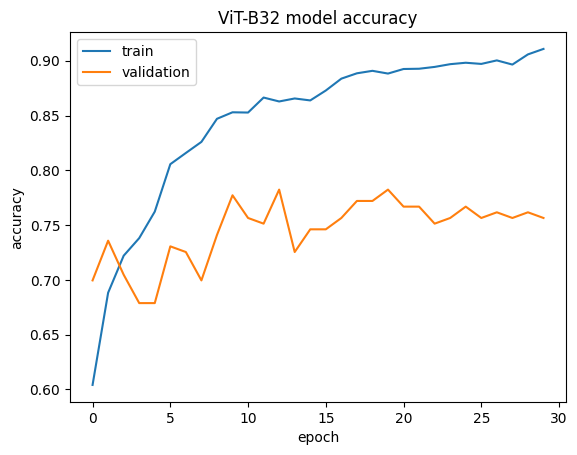

In [21]:
plot_hist(hist, "ViT-B32")

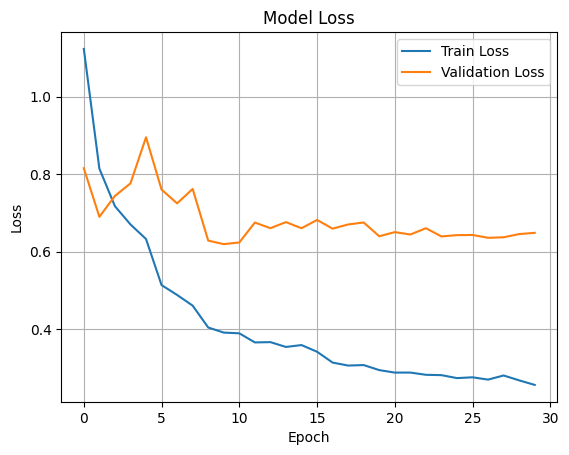

In [22]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


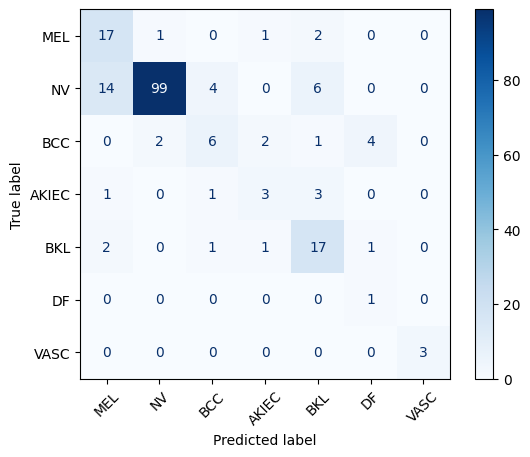

In [23]:
y_true = []
y_pred = []

for images, labels in df_validate:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)

In [24]:
test_loss, *test_metrics = model.evaluate(df_test)
print(f"Test Loss: {test_loss}")
print(f"Test Metrics: {test_metrics}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 153s 810ms/step - accuracy: 0.7674 - loss: 0.7255
Test Loss: 0.8895841836929321
Test Metrics: [0.7149471044540405]


In [25]:
model_save_name = 'modelViT-B32_BayOp_Final.keras'
path = f"/content/drive/MyDrive/Colab Notebooks/skin-cancer-project/saved_models/{model_save_name}"
model.save(path)

In [26]:
val_preds = model.predict(df_validate)
val_preds_labels = np.argmax(val_preds, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step


In [27]:
val_true_labels = []
for _, labels in df_validate:
    val_true_labels.extend(np.argmax(labels.numpy(), axis=1))
val_true_labels = np.array(val_true_labels)

In [28]:
test_preds = model.predict(df_test)
test_preds_labels = np.argmax(test_preds, axis=1)

test_true_labels = []
for _, labels in df_test:
    test_true_labels.extend(np.argmax(labels.numpy(), axis=1))
test_true_labels = np.array(test_true_labels)

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [29]:
# Validation scores
print("Validation Metrics:")
print(m.classification_report(val_true_labels, val_preds_labels, target_names=classes))

# Test scores
print("Test Metrics:")
print(m.classification_report(test_true_labels, test_preds_labels, target_names=classes))

Validation Metrics:
              precision    recall  f1-score   support

         MEL       0.50      0.81      0.62        21
          NV       0.97      0.80      0.88       123
         BCC       0.50      0.40      0.44        15
       AKIEC       0.43      0.38      0.40         8
         BKL       0.59      0.77      0.67        22
          DF       0.17      1.00      0.29         1
        VASC       1.00      1.00      1.00         3

    accuracy                           0.76       193
   macro avg       0.59      0.74      0.61       193
weighted avg       0.81      0.76      0.77       193

Test Metrics:
              precision    recall  f1-score   support

         MEL       0.40      0.70      0.51       171
          NV       0.94      0.75      0.83       909
         BCC       0.57      0.59      0.58        93
       AKIEC       0.47      0.65      0.55        43
         BKL       0.58      0.69      0.63       217
          DF       0.54      0.75      0.63 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

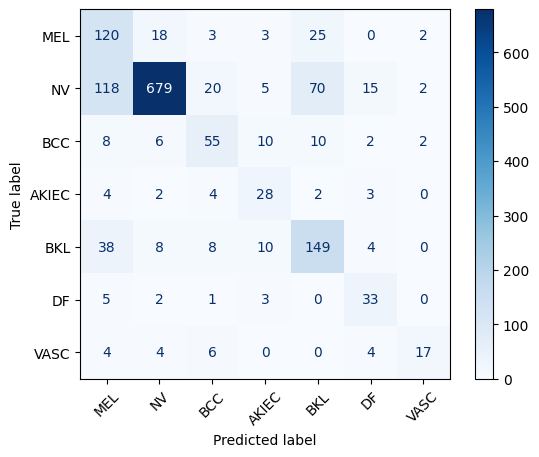

In [30]:
y_true_test = []
y_pred_test = []

for images, labels in df_test:
    preds = model.predict(images)
    y_true_test.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)